# ARGO DOXY profile adjustment check

This script will read in the synthetic profile

1) read the raw and adjusted o2 data in good status (PROFILE_DOXY_QC = 'A' or 'B')
    (A) Flag bad data

2) read the calibration comments: 
    (B) Flag inconsistent / missing DOXY calibration comments
    The correction table is saved as a CSV file as float_calibration_statsitics.csv

3) for the good DOXY profiles, classify the calibration method into 4 groups
- Type 1: Gain correction using surface climatological saturation (Takeshita et al, 2013)
- Type 2: Gain correction using surface in-air measurement at the surface (Johnson et al., 2015)
- Type 3: Drucker and Riser (2016) calibration
- Type 4: Gain correction using deep ocean (1800dbar) climatology

4) Graph the relative proportion of DOXY float profiles

In [24]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate as itp
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

In [25]:
# generate index for downloaded synthetic profiles
os.system('ls data/*.nc > available_floats.txt')
fn=pd.read_csv('available_floats.txt',header=None,names=['file'])

In [3]:
# open the profile data file, count the number of profiles and depth levels
N=np.size(fn)
Nprf=np.empty((N,))
Nprf_good=np.empty((N,))
Nlev=np.empty((N,))
N_calib_comm=np.empty((N,))
calib_comm=np.empty((N,),dtype='U200')
! mkdir -p temporary_files
#
# loop over all floats
for n in range(0,N):
    if (np.remainder(n,50)==0):
        print('completed '+str(n)+' floats')
        
    ds=xr.open_dataset(fn['file'][n])
    Ntmp=np.shape(ds['PRES']) # get pressure data
    Nprf[n]=Ntmp[0]           # count the number of profiles
    Nlev[n]=Ntmp[1]           # count the number of pressure measurements
    # get QC flags
    date_qc=ds['JULD_QC'].astype(int)
    pos_qc=ds['POSITION_QC'].astype(int)
    o2_qc=ds['PROFILE_DOXY_QC'].astype(str)
    o2qcflg=ds['DOXY_QC'].astype(str)
    o2aqcflg=ds['DOXY_ADJUSTED_QC'].astype(str)
    # identify good DOXY profiles    
    goodprf=(pos_qc==1) & (date_qc==1) & ((o2_qc=='A') | (o2_qc=='B'))
    # read in calibration comments for only good profiles
    doxy_calib_comm=ds['SCIENTIFIC_CALIB_COMMENT'][:,0,3].where(goodprf==True).dropna(dim='N_PROF')
    # count the number of good DOXY profiles
    Nprf_good[n]=np.size(doxy_calib_comm)
    # record the calibration method for each profile
    if (Nprf_good[n] >= 1.):
        tmp=np.unique(doxy_calib_comm.to_numpy().astype('U200'))
        N_calib_comm[n]=np.size(tmp)
        tmp10=tmp[0][0:10]
        # check for missing calibration comment
        if ((tmp10=='          ')|(tmp10=='n/a       ')|(tmp10=='none      ')|(tmp10=='No QC avai')):
            calib_comm[n]='inconsistent/missing calibration comment'
            N_calib_comm[n]=np.nan
        # check for inconsistent calibration comment
        elif (N_calib_comm[n]>=2):
            calib_comm[n]='inconsistent/missing calibration comment'
            N_calib_comm[n]=np.nan
        else:
        # this is the good data
            calib_comm[n]=tmp[0]
    # this is not good due to QC flag
    else:
        calib_comm[n]='bad data'
        N_calib_comm[n]=np.nan

completed 0 floats
completed 50 floats
completed 100 floats
completed 150 floats
completed 200 floats
completed 250 floats
completed 300 floats
completed 350 floats
completed 400 floats
completed 450 floats
completed 500 floats
completed 550 floats
completed 600 floats
completed 650 floats
completed 700 floats
completed 750 floats
completed 800 floats
completed 850 floats
completed 900 floats
completed 950 floats
completed 1000 floats
completed 1050 floats
completed 1100 floats
completed 1150 floats
completed 1200 floats
completed 1250 floats
completed 1300 floats
completed 1350 floats
completed 1400 floats
completed 1450 floats
completed 1500 floats


In [26]:
index_good=np.where(N_calib_comm==1)
print('There are '+str(np.size(index_good))+' floats that reported good DOXY data with consistent calibration method comment. ')

There are 949 floats that reported good DOXY data with consistent calibration method comment. 


In [27]:
calib_types, calib_count = np.unique(calib_comm, return_counts=True)
print('There are '+str(np.size(calib_types))+' independent calibration method comments. ')
a=np.array([calib_count, calib_types])
float_stats=pd.DataFrame(data=a.T,
                        columns=['Number of floats','Calibration Type'])
float_stats.to_csv('float_calibration_statsitics.csv')

There are 82 independent calibration method comments. 


In [41]:
Nc=[]
# type 1: Gain correction using surface climatological saturation (WOA). Takeshita et al (2013)
index1=[12,13,14,15,16,19,20,22,23,24,27,28,29,30,31,35,37,38,39,43,44,45,48,49,51,55,56,57,58,59,63,64,65,67,68,70,71,77,78,79,80]
Nc.append(np.sum(calib_count[index1]))
# type 2: Gain correction using surface in-air measurement at the surface (Bittig and Kortzinger 2015; Johnson et al 2015)
index2=[17,18,21,25,26,33,36,40,41,42,46,52,53,54,60,66,72,74]
Nc.append(np.sum(calib_count[index2]))
# type 3: Drucker and Riser (2016) calibration
index3=[34]
Nc.append(np.sum(calib_count[index3]))
# type 4: Gain correction using deep ocean (1800dbar) climatology
index4=[0,1,2,3,4,5,6,7,8]
Nc.append(np.sum(calib_count[index4]))
# type 5: Other
index5=[9,10,11,32,47,50,61,62,69,76,81]
Nc.append(np.sum(calib_count[index5]))

<Figure size 504x288 with 0 Axes>

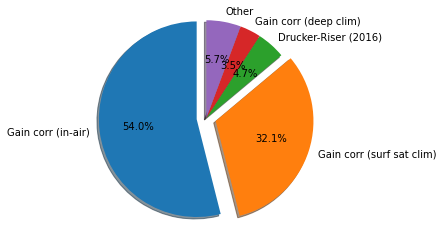

In [44]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(7,4))
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Gain corr (in-air)', 'Gain corr (surf sat clim)', 'Drucker-Riser (2016)', 'Gain corr (deep clim)', 'Other'
sizes = Nc
explode = (0.1, 0.1, 0, 0,0)  # only "explode" the 1st and 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('pie_correction_type.pdf')
plt.show()

In [43]:
Nc

[512, 305, 45, 33, 54]